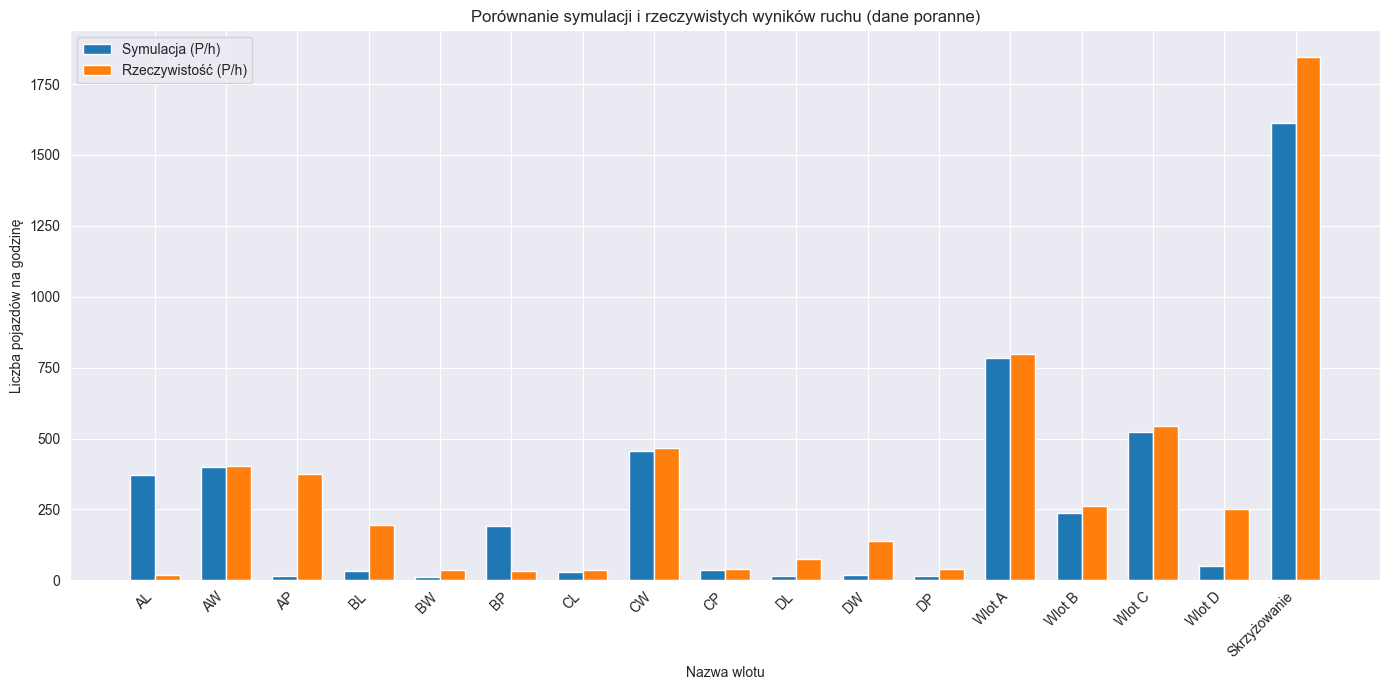


========================== PORÓWNANIE NATĘŻENIA RUCHU ==========================
================================ SZCZYT PORANNY ================================


                                      P/H                                       
--------------------------------------------------------------------------------
     Relacja  Symulacja  Referencja  Różnica bezwzględna  Różnica procentowa
          AL      370.0        20.0                350.0              1750.0
          AP       15.0       375.0               -360.0               -96.0
          AW      400.0       404.0                 -4.0                -1.0
          BL       32.0       194.0               -162.0               -83.5
          BP      193.0        32.0                161.0               503.1
          BW       13.0        37.0                -24.0               -64.9
          CL       29.0        37.0                 -8.0               -21.6
          CP       37.0        41.0                 -4.0 

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def process_fcd_data(fcd_file_path):
    """Przetwarza plik XML FCD do śledzenia ruchu pojazdów."""
    tree = ET.parse(fcd_file_path)
    root = tree.getroot()
    
    # Słowniki do śledzenia pojazdów
    vehicle_paths = {}  # {id_pojazdu: [lista pasów]}
    vehicle_entry_lanes = {}  # {id_pojazdu: pas_wjazdowy}
    vehicle_exit_lanes = {}  # {id_pojazdu: pas_wyjazdowy}
    
    # Przetwarzanie wszystkich kroków czasowych
    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = vehicle.get('id')
            lane = vehicle.get('lane')
            
            # Zapisywanie pasa dla pojazdu w danym kroku czasowym
            if vehicle_id not in vehicle_paths:
                vehicle_paths[vehicle_id] = []
            
            # Dodawanie pasa tylko jeśli różni się od ostatnio zapisanego
            if not vehicle_paths[vehicle_id] or vehicle_paths[vehicle_id][-1] != lane:
                vehicle_paths[vehicle_id].append(lane)
            
            # Zapisywanie pasa wjazdowego (pierwszy pas pojazdu)
            if vehicle_id not in vehicle_entry_lanes:
                vehicle_entry_lanes[vehicle_id] = lane
    
    # Określenie pasów wyjazdowych (ostatni pas pojazdu)
    for vehicle_id, lanes in vehicle_paths.items():
        if lanes:
            vehicle_exit_lanes[vehicle_id] = lanes[-1]
    
    return vehicle_entry_lanes, vehicle_exit_lanes, vehicle_paths

def determine_relation(entry_lane, exit_lane):
    """Mapuje pasy wjazdowe i wyjazdowe na kody relacji."""
    # Mapa podejść
    approach_map = {
        'Ai': 'A',
        'Bi': 'B',
        'Ci': 'C',
        'Di': 'D'
    }
    
    # Mapa kierunków ruchu
    direction_map = {
        # Z A (Piastowska Północ)
        ('Ai', 'Bo'): 'L',  # Lewo do B (Reymonta Wschód)
        ('Ai', 'Co'): 'W',  # Prost do C (Piastowska Południe)
        ('Ai', 'Do'): 'P',  # Prawo do D (Buszka Zachód)
        
        # Z B (Reymonta Wschód)
        ('Bi', 'Ao'): 'P',  # Prawo do A (Piastowska Północ)
        ('Bi', 'Co'): 'L',  # Lewo do C (Piastowska Południe)
        ('Bi', 'Do'): 'W',  # Prost do D (Buszka Zachód)
        
        # Z C (Piastowska Południe)
        ('Ci', 'Ao'): 'W',  # Prost do A (Piastowska Północ)
        ('Ci', 'Bo'): 'P',  # Prawo do B (Reymonta Wschód)
        ('Ci', 'Do'): 'L',  # Lewo do D (Buszka Zachód)
        
        # Z D (Buszka Zachód)
        ('Di', 'Ao'): 'L',  # Lewo do A (Piastowska Północ)
        ('Di', 'Bo'): 'W',  # Prost do B (Reymonta Wschód)
        ('Di', 'Co'): 'P',  # Prawo do C (Piastowska Południe)
    }
    
    # Ekstrakcja podejścia z pasa wjazdowego (np. 'Ai_0' -> 'Ai')
    entry_approach = entry_lane.split('_')[0]
    # Ekstrakcja podejścia z pasa wyjazdowego (np. 'Bo_0' -> 'Bo')
    exit_approach = exit_lane.split('_')[0]
    
    # Pobranie kodu relacji
    relation_key = (entry_approach, exit_approach)
    if relation_key in direction_map:
        approach = approach_map.get(entry_approach, '?')
        direction = direction_map[relation_key]
        return f"{approach}{direction}"
    
    return "Nieznane"

def calculate_flow_rates(vehicle_entry_lanes, vehicle_exit_lanes, simulation_time_seconds):
    """Calculate flow rates for each relation."""
    # Count the number of vehicles for each relation
    relation_counts = defaultdict(int)

    for vehicle_id, entry_lane in vehicle_entry_lanes.items():
        if vehicle_id in vehicle_exit_lanes:
            exit_lane = vehicle_exit_lanes[vehicle_id]
            relation = determine_relation(entry_lane, exit_lane)
            relation_counts[relation] += 1

    # Calculate vehicles per hour
    hours = simulation_time_seconds / 3600
    relation_flow_rates = {relation: count / hours for relation, count in relation_counts.items()}

    # Convert to passenger car equivalent per hour (E/h)
    # Assuming all vehicles are of type 'type1' with PCE=1
    relation_pce_rates = relation_flow_rates.copy()

    # Calculate totals for each entry approach
    approach_totals = defaultdict(int)
    for relation, count in relation_counts.items():
        if len(relation) >= 1:
            approach = relation[0]  # First character is the approach (A, B, C, D)
            approach_totals[f"Wlot {approach}"] += count

    approach_totals_flow = {approach: total / hours for approach, total in approach_totals.items()}
    approach_totals_pce = approach_totals_flow.copy()

    # Calculate total for the entire intersection
    total_count = sum(relation_counts.values())
    total_flow = total_count / hours
    total_pce = total_flow  # Assuming PCE=1 for all vehicles

    return relation_counts, relation_flow_rates, relation_pce_rates, approach_totals_flow, approach_totals_pce, total_flow, total_pce

def create_reference_dataframe():
    """Tworzy DataFrame z wartościami referencyjnymi."""
    # Dane referencyjne dla godziny szczytu porannego (8:00-9:00)
    morning_data = {
        'AL': {'P/h': 20, 'E/h': 20},
        'AW': {'P/h': 404, 'E/h': 410},
        'AP': {'P/h': 375, 'E/h': 374.5},
        'BL': {'P/h': 194, 'E/h': 196},
        'BW': {'P/h': 37, 'E/h': 36.5},
        'BP': {'P/h': 32, 'E/h': 32.5},
        'CL': {'P/h': 37, 'E/h': 37},
        'CW': {'P/h': 465, 'E/h': 468},
        'CP': {'P/h': 41, 'E/h': 40.5},
        'DL': {'P/h': 75, 'E/h': 72},
        'DW': {'P/h': 137, 'E/h': 134.5},
        'DP': {'P/h': 40, 'E/h': 40},
        'Wlot A': {'P/h': 799, 'E/h': 809},
        'Wlot B': {'P/h': 263, 'E/h': 265},
        'Wlot C': {'P/h': 543, 'E/h': 559},
        'Wlot D': {'P/h': 252, 'E/h': 246.5},
        'Skrzyżowanie': {'P/h': 1847, 'E/h': 1879.6}
    }
    
    # Dane referencyjne dla godziny szczytu popołudniowego (15:45-16:45)
    afternoon_data = {
        'AL': {'P/h': 51, 'E/h': 47},
        'AW': {'P/h': 520, 'E/h': 527},
        'AP': {'P/h': 311, 'E/h': 313},
        'BL': {'P/h': 314, 'E/h': 316},
        'BW': {'P/h': 159, 'E/h': 148},
        'BP': {'P/h': 48, 'E/h': 48},
        'CL': {'P/h': 49, 'E/h': 46},
        'CW': {'P/h': 462, 'E/h': 458},
        'CP': {'P/h': 78, 'E/h': 76},
        'DL': {'P/h': 36, 'E/h': 31.5},
        'DW': {'P/h': 42, 'E/h': 41},
        'DP': {'P/h': 21, 'E/h': 21},
        'Wlot A': {'P/h': 882, 'E/h': 887},
        'Wlot B': {'P/h': 2285, 'E/h': 2286},
        'Wlot C': {'P/h': 5159, 'E/h': 5152},
        'Wlot D': {'P/h': 10417, 'E/h': 62},
        'Skrzyżowanie': {'P/h': 2091, 'E/h': 2072.5}
    }
    
    # Połączenie danych w DataFrame
    df_morning = pd.DataFrame([(k, 'poranny', 'P/h', v['P/h']) for k, v in morning_data.items()] + 
                            [(k, 'poranny', 'E/h', v['E/h']) for k, v in morning_data.items()],
                          columns=['Relacja', 'Szczyt', 'Metryka', 'Wartość'])
    
    df_afternoon = pd.DataFrame([(k, 'popołudniowy', 'P/h', v['P/h']) for k, v in afternoon_data.items()] + 
                              [(k, 'popołudniowy', 'E/h', v['E/h']) for k, v in afternoon_data.items()],
                            columns=['Relacja', 'Szczyt', 'Metryka', 'Wartość'])
    
    df = pd.concat([df_morning, df_afternoon])
    
    return df

def compare_with_reference(simulation_results, reference_data, peak_period):
    """Porównuje wyniki symulacji z danymi referencyjnymi i oblicza metryki."""
    # Przygotowanie danych symulacyjnych
    sim_data = []
    for relation, flow_rate in simulation_results['P/h'].items():
        sim_data.append({
            'Relacja': relation,
            'Szczyt': peak_period,
            'Metryka': 'P/h',
            'Symulacja': flow_rate
        })
    
    for relation, pce_rate in simulation_results['E/h'].items():
        sim_data.append({
            'Relacja': relation,
            'Szczyt': peak_period,
            'Metryka': 'E/h',
            'Symulacja': pce_rate
        })
    
    # Tworzenie DataFrame z danych symulacyjnych
    df_sim = pd.DataFrame(sim_data)
    
    # Filtrowanie danych referencyjnych dla określonego szczytu
    df_ref = reference_data[reference_data['Szczyt'] == peak_period].copy()
    
    # Łączenie danych symulacyjnych i referencyjnych
    df_comparison = pd.merge(df_sim, df_ref, on=['Relacja', 'Szczyt', 'Metryka'], how='outer')
    
    # Zmiana nazw kolumn dla jasności
    df_comparison = df_comparison.rename(columns={'Wartość': 'Referencja'})
    
    # Obliczanie różnic bezwzględnych i procentowych
    df_comparison['Różnica bezwzględna'] = df_comparison['Symulacja'] - df_comparison['Referencja']
    df_comparison['Różnica procentowa'] = (df_comparison['Różnica bezwzględna'] / df_comparison['Referencja']) * 100
    
    # Obliczanie metryk: RMSE, MAPE, MAE
    df_valid = df_comparison.dropna(subset=['Symulacja', 'Referencja'])
    
    rmse = np.sqrt(np.mean((df_valid['Symulacja'] - df_valid['Referencja']) ** 2))
    mape = np.mean(np.abs(df_valid['Różnica procentowa']))
    mae = np.mean(np.abs(df_valid['Różnica bezwzględna']))
    
    metrics = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
    plot_compare(simulation_results)
    return df_comparison, metrics

# dane
morning_data = {
    'AL': {'P/h': 20, 'E/h': 20},
    'AW': {'P/h': 404, 'E/h': 410},
    'AP': {'P/h': 375, 'E/h': 374.5},
    'BL': {'P/h': 194, 'E/h': 196},
    'BW': {'P/h': 37, 'E/h': 36.5},
    'BP': {'P/h': 32, 'E/h': 32.5},
    'CL': {'P/h': 37, 'E/h': 37},
    'CW': {'P/h': 465, 'E/h': 468},
    'CP': {'P/h': 41, 'E/h': 40.5},
    'DL': {'P/h': 75, 'E/h': 72},
    'DW': {'P/h': 137, 'E/h': 134.5},
    'DP': {'P/h': 40, 'E/h': 40},
    'Wlot A': {'P/h': 799, 'E/h': 809},
    'Wlot B': {'P/h': 263, 'E/h': 1083},
    'Wlot C': {'P/h': 543, 'E/h': 1633},
    'Wlot D': {'P/h': 252, 'E/h': 40},
    'Skrzyżowanie': {'P/h': 1847, 'E/h': 1861.5}
}

def plot_compare(simulation_results):
    # Przygotowanie danych do wykresu
    nazwy_wlotow = list(morning_data.keys())
    rzeczywistosc = [data['P/h'] for data in morning_data.values()]  # Używam 'P/h' dla rzeczywistości
    symulacja = [simulation_results['P/h'].get(klucz, 0) for klucz in nazwy_wlotow] # Pobieram 'P/h' z wyników symulacji

    # Ustawienie szerokości kolumn i pozycji grup
    szerokosc_kolumny = 0.35
    pozycja_symulacji = np.arange(len(nazwy_wlotow))
    pozycja_rzeczywistosci = [pos + szerokosc_kolumny for pos in pozycja_symulacji]

    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(14, 7))

    # Tworzenie kolumn dla symulacji i rzeczywistości
    rects1 = ax.bar(pozycja_symulacji, symulacja, szerokosc_kolumny, label='Symulacja (P/h)')
    rects2 = ax.bar(pozycja_rzeczywistosci, rzeczywistosc, szerokosc_kolumny, label='Rzeczywistość (P/h)')

    # Dodawanie etykiet i tytułu
    ax.set_ylabel('Liczba pojazdów na godzinę')
    ax.set_xlabel('Nazwa wlotu')
    ax.set_title('Porównanie symulacji i rzeczywistych wyników ruchu (dane poranne)')
    ax.set_xticks(pozycja_symulacji + szerokosc_kolumny / 2)
    ax.set_xticklabels(nazwy_wlotow, rotation=45, ha='right')
    ax.legend()

    # Poprawienie układu, aby etykiety się nie nakładały
    plt.tight_layout()
    plt.show()


def main(fcd_file_path, simulation_time_seconds, peak_period):
    # Przetwarzanie danych FCD
    vehicle_entry_lanes, vehicle_exit_lanes, vehicle_paths = process_fcd_data(fcd_file_path)
    
    # Obliczanie natężeń ruchu
    relation_counts, relation_flow_rates, relation_pce_rates, approach_totals_flow, approach_totals_pce, total_flow, total_pce = calculate_flow_rates(
        vehicle_entry_lanes, vehicle_exit_lanes, simulation_time_seconds)
    
    # Przygotowanie wyników symulacji
    simulation_results = {
        'P/h': {**relation_flow_rates, **approach_totals_flow, 'Skrzyżowanie': total_flow},
        'E/h': {**relation_pce_rates, **approach_totals_pce, 'Skrzyżowanie': total_pce}
    }
    
    # Tworzenie DataFrame z danymi referencyjnymi
    reference_data = create_reference_dataframe()
    
    # Porównanie z danymi referencyjnymi
    df_comparison, metrics = compare_with_reference(simulation_results, reference_data, peak_period)
    
    # Wyświetlanie wyników w formie ładnej tabeli
    print(f"\n{' PORÓWNANIE NATĘŻENIA RUCHU ':=^80}")
    print(f"{' SZCZYT ' + peak_period.upper() + ' ':=^80}\n")
    
    # Formatowanie DataFrame do wyświetlenia
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 120)
    pd.set_option('display.float_format', '{:.1f}'.format)
    
    # Podział na metryki
    for metric in ['P/h', 'E/h']:
        df_metric = df_comparison[df_comparison['Metryka'] == metric].sort_values('Relacja')
        print(f"\n{metric.upper():^80}")
        print("-"*80)
        print(df_metric[['Relacja', 'Symulacja', 'Referencja', 'Różnica bezwzględna', 'Różnica procentowa']].to_string(index=False))
    
    # Wyświetlanie metryk wydajności
    print("\n\n{' METRYKI JAKOŚCI ':=^80}")
    print(f"Średni błąd kwadratowy (RMSE): {metrics['RMSE']:.1f}")
    print(f"Średni błąd procentowy (MAPE): {metrics['MAPE']:.1f}%")
    print(f"Średni błąd bezwzględny (MAE): {metrics['MAE']:.1f}")
    
    # Zapis wyników do pliku CSV
    df_comparison.to_csv(f'porownanie_ruchu_{peak_period}.csv', index=False, encoding='utf-8-sig')
    
  


if __name__ == "__main__":
    # Ścieżka do pliku XML FCD
    fcd_file_path = "fcd_rano.xml"
    
    # Całkowity czas symulacji w sekundach
    simulation_time_seconds = 3600  # 1 godzina
    
    # Okres szczytu do porównania ('poranny' lub 'popołudniowy')
    peak_period = "poranny"  # Zmień na 'popołudniowy' dla szczytu popołudniowego
    
    main(fcd_file_path, simulation_time_seconds, peak_period)
    